In [ ]:
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding, get_cosine_schedule_with_warmup
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

train_df = pd.read_csv('/kaggle/input/nie-pdl23-mid-term-competition/train.csv')
test_df = pd.read_csv('/kaggle/input/nie-pdl23-mid-term-competition/test.csv')

train_df["fold"] = train_df.index % 5

# act_fold = 0
# train_split = train_df[train_df['fold'] != act_fold]
# val_split = train_df[train_df['fold'] == act_fold]

# print(train_split.shape, val_split.shape, train_df.shape)

# train_split.head()

"""
Make use of a `category` column in your solution – 5 points
Add support for dynamic padding – 5 points
Implement Average/Max pooling for the model – 5 points
Add support for mixed precision in training and inference code – 5 points
Add extra feature/idea to your solution that is not listed above – 5 points
"""

In [2]:
# display(train_split[['category', 'difficulty']].groupby('category').mean())
# display(val_split[['category', 'difficulty']].groupby('category').mean())
# print("Train cats: ", train_split.category.unique())
# print("Val cats: ", train_split.category.unique())
# print("Test cats: ", test_df.category.unique())

In [3]:
# Dataset without Padding
class NoPaddingDataset(Dataset):
    def __init__(self, df, backbone, text_col, cat_col, label_col, max_len=64, sample=None):
        texts = df
        if sample:
            texts = texts.sample(sample)
        
        self.tokenizer = AutoTokenizer.from_pretrained(backbone)
        self.texts = texts[text_col].values.tolist()
        self.labels = None if label_col not in texts.columns else texts[label_col].values.tolist()
        self.categories = None if cat_col not in texts.columns else texts[cat_col].values.tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_text = self.texts[idx]
        if self.categories is not None:
            input_text = input_text + self.tokenizer.sep_token + self.categories[idx]
        res = self.tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=self.max_len,
        )
        res = {k:v[0] for k,v in res.items()}
        if self.labels is not None:
            res["target"] = torch.tensor(self.labels[idx])
        
        return res

# Define the Dataset class
class CustomDataset(Dataset):
    def __init__(self, df, backbone, text_col, cat_col, label_col, max_len=64, sample=None):
        texts = df
        if sample:
            texts = texts.sample(sample)
        
        self.tokenizer = AutoTokenizer.from_pretrained(backbone)
        self.texts = texts[text_col].values.tolist()
        self.labels = None if label_col not in texts.columns else texts[label_col].values.tolist()
        self.categories = None if cat_col not in texts.columns else texts[cat_col].values.tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_text = self.texts[idx]
        if self.categories is not None:
            input_text = input_text + self.tokenizer.sep_token + self.categories[idx]
        res = self.tokenizer(
            input_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
        )
        res = {k:v[0] for k,v in res.items()}
        if self.labels is not None:
            res["target"] = torch.tensor(self.labels[idx])
        
        return res
    
    
class Head(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        my_layers = []
        
        for i in range(len(layers)-1):
            my_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i< len(layers)-2:
                my_layers.append(activation())

        self.layers = nn.ModuleList(my_layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class ClsPool(nn.Module):
    def forward(self, x, attention_mask):
        # batch * num_tokens * num_embedding
        return x[:, 0, :]

    
class AvgPool(nn.Module):
    def forward(self, x, attention_mask):
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float()
        return (torch.sum(x * attention_mask_expanded, 1) / torch.clamp(attention_mask_expanded.sum(1), min=1e-9))


class MaxPool(nn.Module):
    def forward(self, x, attention_mask):
        attention_mask_expanded = torch.where(attention_mask==0, -1e-9, 0.).unsqueeze(-1).expand(x.size()).float()
        return torch.max(x-attention_mask_expanded, 1)[0]


class CustomModel(nn.Module):
    def __init__(self, backbone, pool, num_outputs, hidden_layers=None):
        super().__init__()
        
        self.backbone_name = backbone
        self.backbone = AutoModel.from_pretrained(backbone)
        self.pool = pool
        self.num_outputs = num_outputs
        self.dropout = nn.Dropout(p=0.2)

        hidden_layers = hidden_layers if hidden_layers else []
        hidden_layers = [self.backbone.config.hidden_size] + hidden_layers + [num_outputs]
        self.head = Head(hidden_layers)
    
    def forward(self, x, print_shapes=False, apply_sigmoid=False):
        # save for pooling
        attention_mask = x["attention_mask"]
        
        x = self.backbone(**x)["last_hidden_state"]

        if print_shapes:
            print("Backbone output shape", x.shape)

        x = self.pool(x, attention_mask)
        
        if print_shapes:
            print("Pool output shape", x.shape)
        
        x = self.dropout(x)
        
        x = self.head(x)
        if print_shapes:
            print("Head output shape", x.shape)
            
        if apply_sigmoid:
            x = nn.functional.sigmoid(x)
            
        # reduce single dimension
        if self.num_outputs == 1:
            x = x.view(-1)
            
        return x



In [4]:
def accuracy(x, y):
    return accuracy_score(x, [1* (num>0.5) for num in y])


def train_loop(train_dl, model, loss_fn, optimizer, scheduler, device, use_amp=True, log_every=1):
    losses = []
    lr_values = []
    size = len(train_dl)
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # Prepare scaler because of mixed precision
    scaler = GradScaler()
    
    pbar = tqdm(train_dl)
    for batch_idx, batch_dict in enumerate(pbar):
        x = {k:v.to(device) for k, v in batch_dict.items() if k != 'target'}

        # this is necessary for BCEWithLogitLoss
        y = batch_dict["target"].float().to(device)
        
        # Running with mixed precision
        with autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            # Compute prediction and loss
            pred = model(x)   
            loss = loss_fn(pred, y)

        # Backpropagation + scaler because of mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()
        
        if batch_idx % log_every == 0:
            losses.append(loss.detach().cpu().item())
            lr_values.append(scheduler.get_lr()[0])
        
        loss, current = loss.item(), (batch_idx + 1)
        pbar.set_description(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return losses, lr_values


def inference_loop(model, dataloader, device, **predict_kwargs):
    model.to(device)
    predictions = []
    labels = []
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch_dict in tqdm(dataloader):
            x = {k:v.to(device) for k, v in batch_dict.items() if k != 'target'}
            y = batch_dict.get("target")
            
            pred = model(x,  **predict_kwargs)
            # we move predictions to cpu, in case they are stored on GPU
            predictions.extend(pred.cpu().tolist())
            
            if y is not None:
                labels.extend(y.cpu().tolist())
                
    return predictions, labels


def validation_loop(val_dl, model, val_metrics, device):
    predictions, labels = inference_loop(model, val_dl, device, apply_sigmoid=False)
    scores = {metric.__name__: metric(labels, predictions) for metric in val_metrics}
    return scores


def predict(model, test_dl, device, apply_sigmoid=False):
    model.to(device)
    predictions, _ = inference_loop(model, test_dl, device, apply_sigmoid=apply_sigmoid)
    return predictions


def train(model, train_dl, val_dl, loss, optimizer, scheduler, epochs, val_metrics, device, use_amp=True, skip_validation=False):
    scores = []
    losses = []
    lr_rates = []
    
    model.to(device)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")
        epoch_losses, epoch_lr_rates = train_loop(train_dl, model, loss, optimizer, scheduler, device, use_amp=use_amp)
        if not skip_validation:    
            epoch_scores = validation_loop(val_dl, model, val_metrics, device)
            print(epoch_scores)
            scores.append(epoch_scores)
        losses.extend(epoch_losses)
        lr_rates.extend(epoch_lr_rates)
    print("Done!")
    return model, scores, losses, lr_rates

## Train 5 models with different folds
- They will be used as an ensemble

In [5]:
train_fold_losses = {}
val_fold_scores = {}

for fold in range(0,5):
    # Specify all hyper-parameters
    backbone = "microsoft/deberta-v3-base"
    pool = AvgPool()
    learning_rate = 1e-5
    num_classes = 1
    hidden_layers = None
    epochs = 7
    batch_size = 8
    num_tokens = 128
    device = "cuda"
    val_metrics = [mean_absolute_error]
    loss = nn.L1Loss()
    sample = None #10*batch_size
    use_amp = True
    skip_validation = False
    full_dataset = False


    model = CustomModel(backbone, pool, num_classes, hidden_layers)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Dynamic padding for each batch
    collator = DataCollatorWithPadding(
        tokenizer=AutoTokenizer.from_pretrained(backbone),
        return_tensors='pt',
        padding='longest'
    )

    train_split = train_df[train_df['fold'] != fold]
    val_split = train_df[train_df['fold'] == fold]

    if full_dataset:
        # Get datasets and data loaders
        train_ds = NoPaddingDataset(train_df, backbone, "question", "category", "difficulty", sample=sample, max_len=num_tokens)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collator)
        val_dl = None
    else:
        # Get datasets and data loaders
        train_ds = NoPaddingDataset(train_split, backbone, "question", "category", "difficulty", sample=sample, max_len=num_tokens)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collator)

        # Get datasets and data loaders
        val_ds = NoPaddingDataset(val_split, backbone, "question", "category", "difficulty", sample=sample, max_len=num_tokens)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=collator)

    # Get scheduler
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=400, num_training_steps=epochs * len(train_dl))

    print(f'TRAINING ON FOLD {fold}\n=============================================\n');
    # Train model
    model, val_scores, train_losses, lr_rates = train(model, train_dl, val_dl, loss, optimizer, scheduler, epochs, val_metrics, device,
                                                      use_amp=use_amp, skip_validation=skip_validation)

    # Save model weights
    torch.save(model.state_dict(), f'model_weights_fold{fold}.pth')

    # Store fold scores and losses
    train_fold_losses[fold] = train_losses
    val_fold_scores[fold] = []
    for val_score in val_scores:
        val_fold_scores[fold].append(val_score['mean_absolute_error'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added

TRAINING ON FOLD 0

Epoch 1/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 34.82it/s]


{'mean_absolute_error': 1.448498902675168}
Epoch 2/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.71it/s]


{'mean_absolute_error': 1.34678426984663}
Epoch 3/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.66it/s]


{'mean_absolute_error': 1.2447752328387724}
Epoch 4/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.08it/s]


{'mean_absolute_error': 1.1921488902886217}
Epoch 5/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.78it/s]


{'mean_absolute_error': 1.176977942879355}
Epoch 6/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.58it/s]


{'mean_absolute_error': 1.2089918186144193}
Epoch 7/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.19it/s]


{'mean_absolute_error': 1.2102086914489882}
Done!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added

TRAINING ON FOLD 1

Epoch 1/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.40it/s]


{'mean_absolute_error': 1.3014657011157589}
Epoch 2/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.95it/s]


{'mean_absolute_error': 1.2288751039342614}
Epoch 3/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.14it/s]


{'mean_absolute_error': 1.2293143708824004}
Epoch 4/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.66it/s]


{'mean_absolute_error': 1.1645417720448492}
Epoch 5/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.12it/s]


{'mean_absolute_error': 1.1986632984212309}
Epoch 6/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.67it/s]


{'mean_absolute_error': 1.166283776608783}
Epoch 7/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.82it/s]


{'mean_absolute_error': 1.1660267383136986}
Done!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added

TRAINING ON FOLD 2

Epoch 1/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.32it/s]


{'mean_absolute_error': 1.3409163739956413}
Epoch 2/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.43it/s]


{'mean_absolute_error': 1.2380784923119845}
Epoch 3/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.57it/s]


{'mean_absolute_error': 1.2499318295075486}
Epoch 4/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.08it/s]


{'mean_absolute_error': 1.2152083739118924}
Epoch 5/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.68it/s]


{'mean_absolute_error': 1.1492832241180237}
Epoch 6/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.32it/s]


{'mean_absolute_error': 1.1655858812823396}
Epoch 7/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.03it/s]


{'mean_absolute_error': 1.1724502995991135}
Done!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added

TRAINING ON FOLD 3

Epoch 1/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.11it/s]


{'mean_absolute_error': 1.547024318753611}
Epoch 2/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.13it/s]


{'mean_absolute_error': 1.4529740253591796}
Epoch 3/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.51it/s]


{'mean_absolute_error': 1.2339421832035162}
Epoch 4/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.45it/s]


{'mean_absolute_error': 1.2219566184822483}
Epoch 5/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.49it/s]


{'mean_absolute_error': 1.2456265754888078}
Epoch 6/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.38it/s]


{'mean_absolute_error': 1.226050420660644}
Epoch 7/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 37.25it/s]


{'mean_absolute_error': 1.2313238490375782}
Done!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added

TRAINING ON FOLD 4

Epoch 1/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.10it/s]


{'mean_absolute_error': 1.3719526509921003}
Epoch 2/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.36it/s]


{'mean_absolute_error': 1.1857702783795865}
Epoch 3/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.90it/s]


{'mean_absolute_error': 1.2474060141236907}
Epoch 4/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.13it/s]


{'mean_absolute_error': 1.1985790241512562}
Epoch 5/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 36.04it/s]


{'mean_absolute_error': 1.1614706606757816}
Epoch 6/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.61it/s]


{'mean_absolute_error': 1.173219215768331}
Epoch 7/7
-------------------------------


100%|██████████| 162/162 [00:04<00:00, 35.85it/s]


{'mean_absolute_error': 1.1614467399606032}
Done!


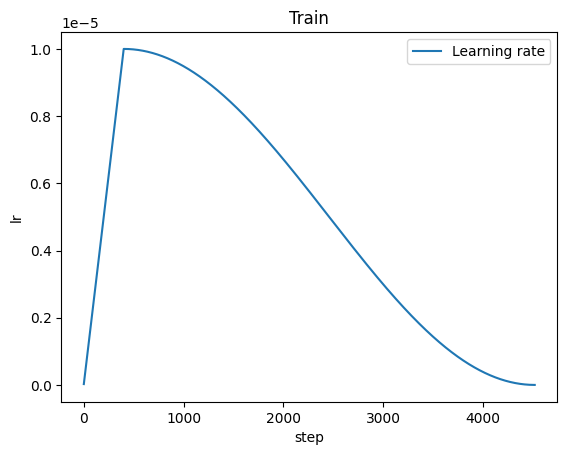

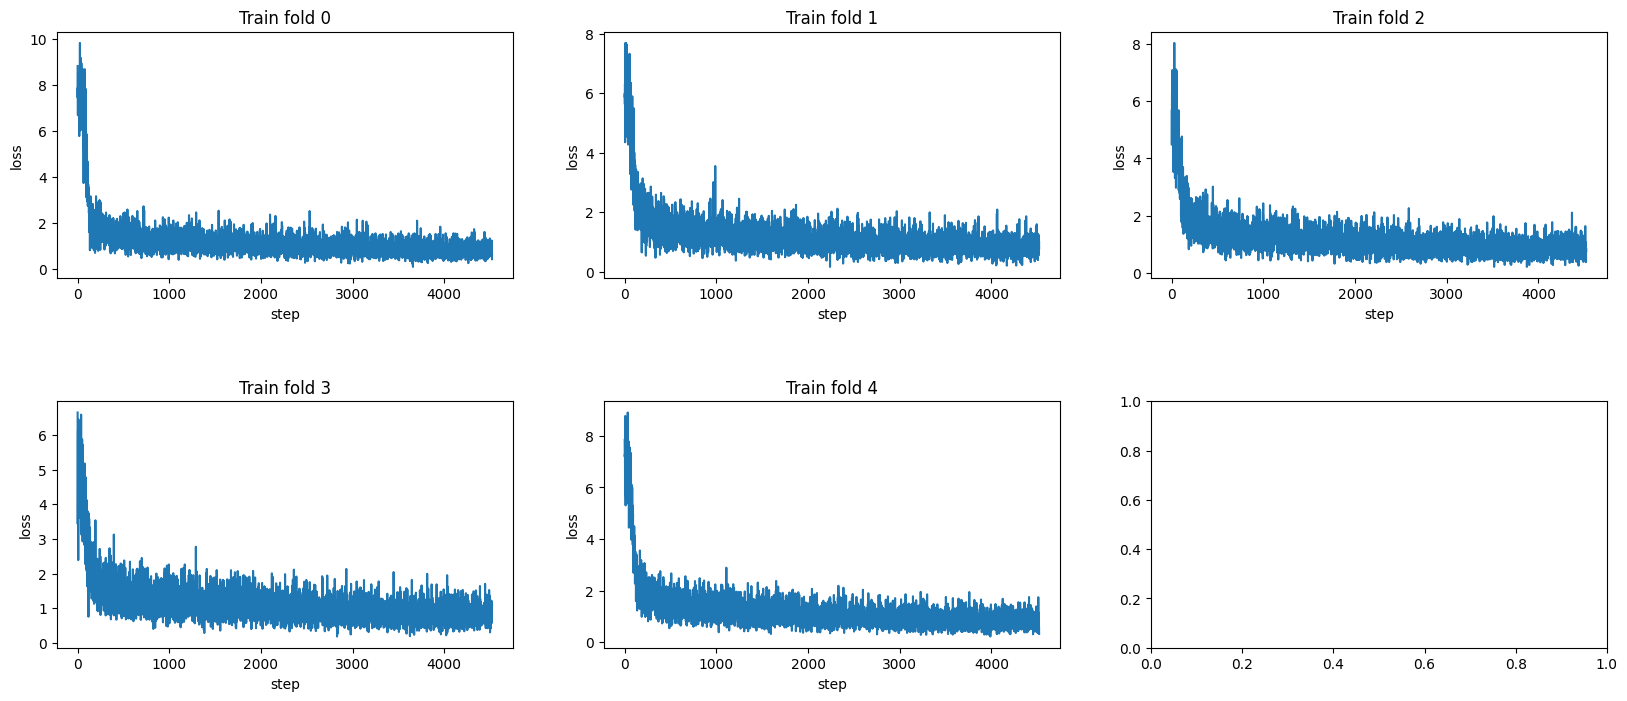

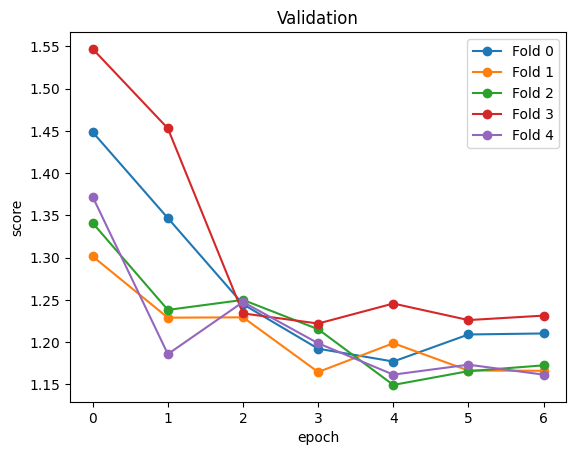

In [6]:
import matplotlib.pyplot as plt

pd.DataFrame({"Learning rate":lr_rates}).plot(xlabel="step", ylabel="lr", style="-", title="Train")

fig, axs = plt.subplots(2, 3, figsize=(20, 8))

for i, (k, v) in enumerate(train_fold_losses.items()):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.plot(v, label=f'Fold {k}')

    ax.set_xlabel('step')
    ax.set_ylabel('loss')
    ax.set_title(f'Train fold {k}')

plt.subplots_adjust(hspace=0.5)
plt.show()

for key, values in val_fold_scores.items():
    plt.plot(values, label=f'Fold {key}', marker='o')
    
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('Validation')
plt.legend()
plt.show()

## Save submissions from each fold

In [7]:
# Get test dataset and data loader
test_ds = NoPaddingDataset(test_df, backbone, "question", "category", None, max_len=num_tokens)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collator)

# Predict values for each fold
for fold in range(0,5):
    # Define model and load weights
    loaded_model = CustomModel(backbone, pool, num_classes, hidden_layers)
    print(f"Loading weights for fold {fold}")
    loaded_model.load_state_dict(torch.load(f'model_weights_fold{fold}.pth'))

    # Set model to inference mode
    loaded_model.eval()

    preds = predict(loaded_model, test_dl, device)

    sub = pd.DataFrame({'id': test_df['id'].values, 'difficulty':preds})
    sub.to_csv(f"submission_fold{fold}.csv", index=False)
    
    # Round the predictions as the difficulty values are whole numbers
    sub.loc[:,'difficulty'] = sub.difficulty.round()
    sub['difficulty'] = sub['difficulty'].replace(11, 10)
    sub['difficulty'] = sub['difficulty'].replace(0, 1)
    sub.to_csv(f"submission_rounded_fold{fold}.csv", index=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading weights for fold 0


100%|██████████| 250/250 [00:07<00:00, 34.30it/s]


Loading weights for fold 1


100%|██████████| 250/250 [00:07<00:00, 34.94it/s]


Loading weights for fold 2


100%|██████████| 250/250 [00:07<00:00, 35.15it/s]


Loading weights for fold 3


100%|██████████| 250/250 [00:07<00:00, 35.08it/s]


Loading weights for fold 4


100%|██████████| 250/250 [00:07<00:00, 35.12it/s]


## Train one model on all the data

In [8]:
# Specify all hyper-parameters
backbone = "microsoft/deberta-v3-base"
pool = AvgPool()
learning_rate = 1e-5
num_classes = 1
hidden_layers = None
epochs = 8
batch_size = 8
num_tokens = 128
device = "cuda"
val_metrics = [mean_absolute_error]
loss = nn.L1Loss()
sample = None #10*batch_size
use_amp = True
skip_validation = True


model_all = CustomModel(backbone, pool, num_classes, hidden_layers)
optimizer = torch.optim.AdamW(model_all.parameters(), lr=learning_rate)

# Dynamic padding for each batch
collator = DataCollatorWithPadding(
    tokenizer=AutoTokenizer.from_pretrained(backbone),
    return_tensors='pt',
    padding='longest'
)

# Get datasets and data loaders
train_ds = NoPaddingDataset(train_df, backbone, "question", "category", "difficulty", sample=sample, max_len=num_tokens)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collator)
val_dl = None

# Get scheduler
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=600, num_training_steps=epochs * len(train_dl))

print(f'TRAINING ON ALL DATA\n=============================================\n');
# Train model
model_all, val_scores, train_losses, lr_rates = train(model_all, train_dl, val_dl, loss, optimizer, scheduler, epochs, val_metrics, device,
                                                  use_amp=use_amp, skip_validation=skip_validation)

# Save model weights
torch.save(model_all.state_dict(), f'model_weights_all_data.pth')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


TRAINING ON ALL DATA

Epoch 1/8
-------------------------------


loss: 1.277344  [  808/  808]: 100%|██████████| 808/808 [01:41<00:00,  7.97it/s]


Epoch 2/8
-------------------------------


loss: 0.062500  [  808/  808]: 100%|██████████| 808/808 [01:40<00:00,  8.04it/s]


Epoch 3/8
-------------------------------


loss: 1.259766  [  808/  808]: 100%|██████████| 808/808 [01:41<00:00,  7.99it/s]


Epoch 4/8
-------------------------------


loss: 0.041016  [  808/  808]: 100%|██████████| 808/808 [01:40<00:00,  8.01it/s]


Epoch 5/8
-------------------------------


loss: 1.582031  [  808/  808]: 100%|██████████| 808/808 [01:40<00:00,  8.05it/s]


Epoch 6/8
-------------------------------


loss: 0.546875  [  808/  808]: 100%|██████████| 808/808 [01:40<00:00,  8.06it/s]


Epoch 7/8
-------------------------------


loss: 0.703125  [  808/  808]: 100%|██████████| 808/808 [01:40<00:00,  8.03it/s]


Epoch 8/8
-------------------------------


loss: 0.089844  [  808/  808]: 100%|██████████| 808/808 [01:40<00:00,  8.02it/s]


Done!


In [9]:
model_all.eval()

preds = predict(model_all, test_dl, device)

sub = pd.DataFrame({'id': test_df['id'].values, 'difficulty':preds})
sub.to_csv(f"submission_all_data.csv", index=False)

# Round the predictions as the difficulty values are whole numbers
sub.loc[:,'difficulty'] = sub.difficulty.round()
sub['difficulty'] = sub['difficulty'].replace(11, 10)
sub['difficulty'] = sub['difficulty'].replace(0, 1)
sub.to_csv(f"submission_rounded_all_data.csv", index=False)

100%|██████████| 250/250 [00:07<00:00, 34.91it/s]


In [10]:
# Create submission by taking mean of all fold submissions
df0 = pd.read_csv('submission_fold0.csv')
df1 = pd.read_csv('submission_fold1.csv')
df2 = pd.read_csv('submission_fold2.csv')
df3 = pd.read_csv('submission_fold3.csv')
df4 = pd.read_csv('submission_fold4.csv')
df_all = pd.read_csv('submission_all_data.csv')

merged_df = pd.concat([df0, df1, df2, df3, df4, df_all]).groupby('id').mean().reset_index()
merged_df.loc[:,'difficulty'] = merged_df.difficulty.round()
merged_df['difficulty'] = merged_df['difficulty'].replace(11, 10)
merged_df['difficulty'] = merged_df['difficulty'].replace(0, 1)
merged_df.to_csv('submission.csv', index=False)